In [56]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict


In [57]:
def load_graph(path):
    return nx.read_edgelist(path, nodetype=int)

G_ba = load_graph("data/ba.txt")
G_er = load_graph("data/er.txt")

print(G_ba.number_of_nodes(), G_ba.number_of_edges())
print(G_er.number_of_nodes(), G_er.number_of_edges())


1000 3990
999 4000


In [58]:
bc_ba = nx.betweenness_centrality(G_ba)
bc_er = nx.betweenness_centrality(G_er)

In [59]:
def vaccinate_random(G, k, name="no"):
    return random.sample(list(G.nodes()), k)

def vaccinate_high_degree(G, k, name="no"):
    degree_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)
    return [node for node, _ in degree_sorted[:k]]

def vaccinate_high_betweenness(G, k, name="no"):
    if name == "no":
        print("wrong graph specification")
        return
    elif name == "BA":
        bc = bc_ba
    elif name == "ER":
        bc = bc_er
    
    sorted_nodes = sorted(bc.items(), key=lambda x: x[1], reverse=True)
    return [node for node, _ in sorted_nodes[:k]]


In [ ]:
def sir_simulation_influence(G, seeds, beta=0.05, gamma=1.0, time_period=10000):
    # states: 0-S, 1-I, 2-R
    state = {node: 0 for node in G.nodes()}

    # seed nodes start as infected
    for v in seeds:
        state[v] = 1

    infected_counts = []

    for _ in range(time_period):
        new_state = state.copy()
        infected_now = [n for n in G.nodes() if state[n] == 1]
        infected_counts.append(len(infected_now))

        if len(infected_now) == 0:
            break

        for node in infected_now:
            for nbr in G.neighbors(node):
                if state[nbr] == 0 and random.random() < beta:
                    new_state[nbr] = 1

            if random.random() < gamma:
                new_state[node] = 2

        state = new_state

    # number of nodes that have information at the end (R)
    informed_final = len([n for n in G.nodes() if state[n] == 2])

    return infected_counts, informed_final


In [61]:
def run_experiment_influence(G, k, strategy_fn, g_name, runs=100):
    infected_auc = []
    informed_final = []

    for _ in range(runs):
        seeds = strategy_fn(G, k, g_name)
        infected_overtime, informed = sir_simulation_influence(G, seeds)
        infected_auc.append(sum(infected_overtime))
        informed_final.append(informed)

    return infected_auc, informed_final


In [66]:
strategies = {
    "Random": vaccinate_random,
    "High-degree": vaccinate_high_degree,
    "High-betweenness": vaccinate_high_betweenness
}
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
runs = 100
results_inf_k = {}

for net_name, G in [("BA", G_ba), ("ER", G_er)]:
    print(f"{net_name} network (Influence Maximization, k start)")
    print(f"Nodes: {G.number_of_nodes()}")
    results_inf_k[net_name] = {}

    for strat_name, strat_fn in strategies.items():
        R_means = []

        for k in k_list:
            _, informed_vals = run_experiment_influence(G, k, strat_fn, net_name, runs)
            R_means.append(np.mean(informed_vals))

        results_inf_k[net_name][strat_name] = R_means
        print(f"{strat_name:16s} | R(k): {R_means}")


BA network (Influence Maximization, k start)
Nodes: 1000
Random           | R(k): [61.1, 93.68, 121.48, 139.05, 159.1, 167.58, 180.58, 197.0, 207.56, 221.28]
High-degree      | R(k): [123.82, 146.05, 163.35, 175.36, 187.9, 198.65, 212.97, 222.94, 233.42, 243.26]
High-betweenness | R(k): [123.2, 147.11, 161.71, 174.56, 189.82, 198.45, 211.15, 222.61, 233.43, 244.93]
ER network (Influence Maximization, k start)
Nodes: 999
Random           | R(k): [16.66, 32.34, 49.7, 64.24, 80.92, 94.13, 110.26, 125.88, 140.52, 153.12]
High-degree      | R(k): [25.03, 44.01, 63.38, 81.87, 98.56, 117.38, 131.09, 147.59, 163.04, 175.0]
High-betweenness | R(k): [23.75, 43.82, 60.47, 78.95, 98.23, 113.97, 133.09, 147.77, 160.62, 172.87]


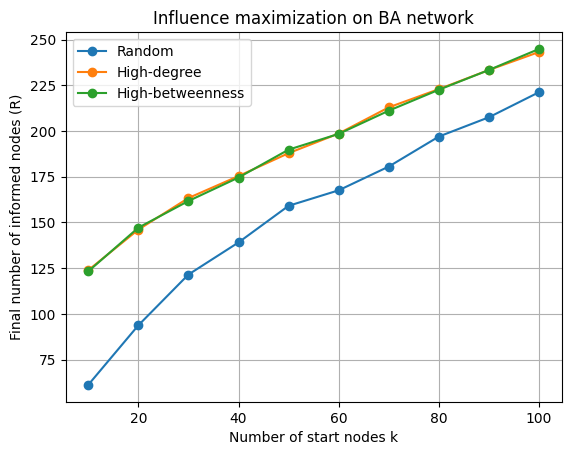

In [67]:
plt.figure()

for strat_name in strategies:
    plt.plot(
        k_list,
        results_inf_k["BA"][strat_name],
        marker="o",
        label=strat_name
    )

plt.xlabel("Number of start nodes k")
plt.ylabel("Final number of informed nodes (R)")
plt.title("Influence maximization on BA network")
plt.legend()
plt.grid(True)
plt.show()


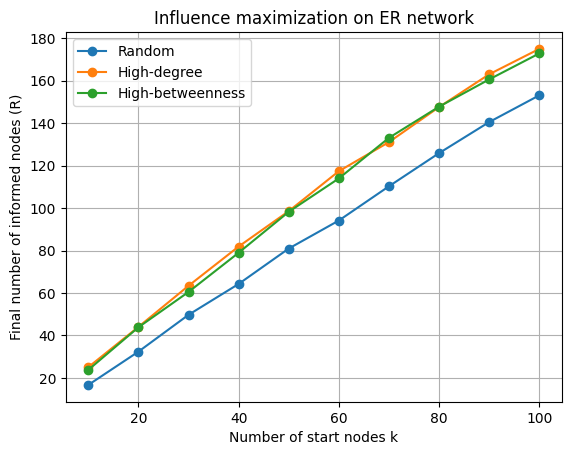

In [68]:
plt.figure()

for strat_name in strategies:
    plt.plot(
        k_list,
        results_inf_k["ER"][strat_name],
        marker="o",
        label=strat_name
    )

plt.xlabel("Number of start nodes k")
plt.ylabel("Final number of informed nodes (R)")
plt.title("Influence maximization on ER network")
plt.legend()
plt.grid(True)
plt.show()
